In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.engine as ue
import utils.engine0d as ue0d
import utils.visualizer as uv

In [3]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2

In [4]:
plt.rcParams["animation.html"] = "jshtml"

In [5]:
def make_linear_profile_ice(h_ice, T_ib, T_is, N_cells):
    dz_cells = np.ones(N_cells)*(h_ice/N_cells)
    T_cells = T_ib + np.arange(0.5, N_cells)/N_cells * (T_is - T_ib)
    return dz_cells, T_ib, T_cells, T_is

In [6]:
make_linear_profile_ice(2.0, 0.0, -10.0, 10)

(array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]),
 0.0,
 array([-0.5, -1.5, -2.5, -3.5, -4.5, -5.5, -6.5, -7.5, -8.5, -9.5]),
 -10.0)

# 1.Тестирование функции ice_freezing_0d (и сравнение с ice_freezing)

In [ ]:
def test_ice_freezing_0d(N, # количество ячеек в сетке вывода
                         N_time_steps,
                         N_pseudoiter,
                         time_step,
                         thickness_init,
                         T_a,
                         T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_prev, thickness_prev = 0.0, 0.0
    T_ia_new, thickness_new = T_a(0.0)/2.0 , thickness_init
    
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
   
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, thickness_prev = T_ia_new, thickness_new 
        
        T_ia_new, thickness_new = \
        ue0d.ice_freezing_0d(Toi=T_ib_init,
                             Tia_init=T_ia_prev,
                             F_atm=F_atm,
                             F_ocn=F_ocn,
                             thickness_i_init=thickness_prev,
                             N_pseudoiter=N_pseudoiter,
                             time_step=time_step)
        
        # вывод
        dz_cells_ice, T_ib, T_cells, T_is = make_linear_profile_ice(h_ice=thickness_new,
                                                                    T_ib=T_o(time),
                                                                    T_is=T_ia_new,
                                                                    N_cells=N)
        
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
def test_ice_freezing_1d(N,
                         N_time_steps,
                         N_pseudoiter,
                         time_step,
                         thickness_init,
                         T_a,
                         T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_new = T_a(0.0)/2.0
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    T_ia_prev, dz_cells_ice_prev =  T_is_init, dz_cells_ice_init
    dz_cells_ice_new = dz_cells_ice_init
    T_cells_prev , T_cells_new = T_cells_init, T_cells_init
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, dz_cells_ice_prev, T_cells_prev = T_ia_new, dz_cells_ice_new, T_cells_new 
        
        T_cells_new, T_ia_new, dz_cells_ice_new = \
        ue.ice_freezing(Toi=T_ib_init,
                        Ti=T_cells_prev,
                        Tia=T_ia_prev,
                        F_atm=F_atm,
                        F_ocn=F_ocn,
                        F_sw=0.0,
                        dzi=dz_cells_ice_prev,
                        salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                        N_pseudoiter=N_pseudoiter,
                        time_step=time_step,
                        tol=1e-12)
        
        # вывод
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice_new.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells_new.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_ia_new)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
# расчет тестов
test_ice_freezing_process_0d = test_ice_freezing_0d(N=10,
                                                    N_time_steps=500,
                                                    N_pseudoiter=50,
                                                    time_step=3600.0,
                                                    thickness_init=1.0,
                                                    T_a=lambda time: -20.0,
                                                    T_o=lambda time: ue.Tf_i(30.0))

test_ice_freezing_process_1d = test_ice_freezing_1d(N=10,
                                                    N_time_steps=500,
                                                    N_pseudoiter=50,
                                                    time_step=3600.0,
                                                    thickness_init=1.0,
                                                    T_a=lambda time: -20.0,
                                                    T_o=lambda time: ue.Tf_i(30.0))

In [ ]:
# анимация
uv.animate([test_ice_freezing_process_0d, test_ice_freezing_process_1d], names=['0D', '1D'])

In [ ]:
# временной ряд разности
uv.timeseries_err(process_sim=test_ice_freezing_process_1d,
                  process_data=test_ice_freezing_process_0d,
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

# 2.Тестирование функции ice_melting_0d (и сравнение с ice_melting)

In [ ]:
def test_ice_melting_0d(N,
                        N_time_steps,
                        N_pseudoiter,
                        time_step,
                        thickness_init,
                        T_a,
                        T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_prev, thickness_prev = 0.0, 0.0
    T_ia_new, thickness_new = T_a(0.0)/2.0 , thickness_init
    
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, thickness_prev = T_ia_new, thickness_new
        
        T_ia_new, thickness_new = \
        ue0d.ice_freezing_0d(Toi=T_ib_init,
                             Tia_init=T_ia_prev,
                             F_atm=F_atm,
                             F_ocn=F_ocn,
                             thickness_i_init=thickness_prev,
                             N_pseudoiter=N_pseudoiter,
                             time_step=time_step)
        
        if (T_ia_new >= ue.Tf_i(1.0)):
            
            T_ia_new = ue.Tf_i(1.0)
            
            thickness_new = \
            ue0d.ice_melting_0d(Toi=T_ib_init,
                                F_atm=F_atm,
                                F_ocn=F_ocn,
                                thickness_i_init=thickness_prev,
                                N_pseudoiter=N_pseudoiter,
                                time_step=time_step)
            
            print('ice melting')
            
        else:
            print('ice freezing')
        
        # вывод
        
        dz_cells_ice, T_ib, T_cells, T_is = make_linear_profile_ice(h_ice=thickness_new,
                                                                    T_ib=T_o(time),
                                                                    T_is=T_ia_new,
                                                                    N_cells=N)
        
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
def test_ice_melting_1d(N,
                        N_time_steps,
                        N_pseudoiter,
                        time_step,
                        thickness_init,
                        T_a,
                        T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_new = T_a(0.0)/2.0
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    T_ia_prev, dz_cells_ice_prev =  T_is_init, dz_cells_ice_init
    dz_cells_ice_new = dz_cells_ice_init
    T_cells_prev , T_cells_new = T_cells_init, T_cells_init
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, dz_cells_ice_prev, T_cells_prev = T_ia_new, dz_cells_ice_new, T_cells_new 
        
        T_cells_new, T_ia_new, dz_cells_ice_new = \
        ue.ice_freezing(Toi=T_ib_init,
                        Ti=T_cells_prev,
                        Tia=T_ia_prev,
                        F_atm=F_atm,
                        F_ocn=F_ocn,
                        F_sw=0.0,
                        dzi=dz_cells_ice_prev,
                        salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                        N_pseudoiter=N_pseudoiter,
                        time_step=time_step,
                        tol=1e-12)
        
        if (T_ia_new >= ue.Tf_i(1.0)):
            
            T_ia_new = ue.Tf_i(1.0)
            
            T_cells_new, dz_cells_ice_new = \
            ue.ice_melting(Toi=T_ib_init,
                           Ti=T_cells_prev,
                           Tia_old=T_ia_prev,
                           F_atm=F_atm,
                           F_ocn=F_ocn,
                           F_sw=0.0,
                           dzi=dz_cells_ice_prev,
                           salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                           N_pseudoiter=N_pseudoiter,
                           time_step=time_step,
                           tol=1e-12)
            
            print('ice melting')
            
        else:
            print('ice freezing')
        
        # вывод
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice_new.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells_new.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_ia_new)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
def warming_atmosphere(time, total_time, low_temp, high_temp):
    if (time <= total_time/2.0):
        return low_temp + (high_temp - low_temp)/(0.5*total_time)*time
    return high_temp

In [ ]:
plt.figure(figsize=(20, 10))
T_interval = np.arange(500)*3600
plt.plot(T_interval, [warming_atmosphere(T, 500*3600, -20.0, 10.0) for T in T_interval])
plt.grid()
plt.show()

In [ ]:
test_ice_melting_process_0d = test_ice_melting_0d(N=10,
                                                  N_time_steps=500,
                                                  N_pseudoiter=50,
                                                  time_step=3600.0,
                                                  thickness_init=1.0,
                                                  T_a=lambda time: warming_atmosphere(time, 500*3600.0, -20.0, 5.0),
                                                  T_o=lambda time: ue.Tf_i(30.0))

test_ice_melting_process_1d = test_ice_melting_1d(N=10,
                                                  N_time_steps=500,
                                                  N_pseudoiter=50,
                                                  time_step=3600.0,
                                                  thickness_init=1.0,
                                                  T_a=lambda time: warming_atmosphere(time, 500*3600.0, -20.0, 5.0),
                                                  T_o=lambda time: ue.Tf_i(30.0))

In [ ]:
uv.animate([test_ice_melting_process_0d, test_ice_melting_process_1d], names=['0D','1D'])

In [ ]:
# временной ряд разности
uv.timeseries_err(process_sim=test_ice_melting_process_1d,
                  process_data=test_ice_melting_process_0d,
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

# 3.Тестирование функции snow_ice_freezing_0d (и сравнение с snow_ice_freezing)

In [ ]:
def test_snow_ice_freezing_0d(N,
                              N_time_steps,
                              N_pseudoiter,
                              time_step,
                              ice_thickness_init,
                              snow_thickness_init,
                              T_a,
                              p,
                              T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_sa_new = T_a(0.0)/2.0
    T_is_new = T_a(0.0)/5.0
    dz_cells_ice_init, T_ib_init, T_ice_cells_init, T_is_init = make_linear_profile_ice(h_ice=ice_thickness_init,
                                                                                        T_ib=T_o(0.0),
                                                                                        T_is=T_is_new,
                                                                                        N_cells=N)
    
    dz_cells_snow_init, T_is_init, T_snow_cells_init, T_sa_init = make_linear_profile_ice(h_ice=snow_thickness_init,
                                                                                          T_ib=T_is_new,
                                                                                          T_is=T_sa_new,
                                                                                          N_cells=10)
    
    T_is_prev, T_sa_prev =  T_is_new, T_sa_new
    thickness_ice_prev, thickness_snow_prev = ice_thickness_init, snow_thickness_init
    thickness_ice_new, thickness_snow_new = ice_thickness_init, snow_thickness_init
    
    process = ue.Process([dz_cells_ice_init], [dz_cells_snow_init],
                         [0.0],
                         [T_ib_init], [T_ice_cells_init], [T_is_init], [T_snow_cells_init], [T_sa_init],
                         [[ue.rho_i]*N],
                         [True])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_is_prev, T_sa_prev = T_is_new, T_sa_new
        thickness_ice_prev, thickness_snow_prev = thickness_ice_new, thickness_snow_new
        
        T_is_new, T_sa_new, thickness_ice_new, thickness_snow_new = \
        ue0d.snow_ice_freezing_0d(Toi=T_ib_init,
                                  Tis_init=T_is_prev,
                                  Tsa_init=T_sa_prev,
                                  Ta=T_a(time),
                                  F_atm=F_atm,
                                  F_ocn=F_ocn,
                                  ice_thickness_init=thickness_ice_prev,
                                  snow_thickness_init=thickness_snow_prev,
                                  N_pseudoiter=N_pseudoiter,
                                  time_step=time_step,
                                  p=p(time))
        
        # вывод
        dz_cells_ice, T_ib, T_ice_cells, T_is = make_linear_profile_ice(h_ice=thickness_ice_new,
                                                                        T_ib=T_o(0.0),
                                                                        T_is=T_is_new,
                                                                        N_cells=N)
    
        dz_cells_snow, T_is_init, T_snow_cells, T_sa = make_linear_profile_ice(h_ice=thickness_snow_new,
                                                                               T_ib=T_is_new,
                                                                               T_is=T_sa_new,
                                                                               N_cells=10)
        
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [dz_cells_snow.copy()], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_ice_cells.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is)
        process.snow_temp_history = np.append(process.snow_temp_history, [T_snow_cells.copy()], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, T_sa)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, True)
        
        print('time = ', time)
    
    return process

In [ ]:
def test_snow_ice_freezing_1d(N,
                              N_time_steps,
                              N_pseudoiter,
                              time_step,
                              ice_thickness_init,
                              snow_thickness_init,
                              T_a,
                              p,
                              T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_sa_new = T_a(0.0)/2.0
    T_is_new = T_a(0.0)/5.0
    dz_cells_ice_init, T_ib_init, T_ice_cells_init, T_is_init = make_linear_profile_ice(h_ice=ice_thickness_init,
                                                                                        T_ib=T_o(0.0),
                                                                                        T_is=T_is_new,
                                                                                        N_cells=N)
    
    dz_cells_snow_init, T_is_init, T_snow_cells_init, T_sa_init = make_linear_profile_ice(h_ice=snow_thickness_init,
                                                                                          T_ib=T_is_new,
                                                                                          T_is=T_sa_new,
                                                                                          N_cells=10)
    
    T_is_prev, T_sa_prev =  T_is_new, T_sa_new
    dz_cells_ice_new, dz_cells_snow_new = dz_cells_ice_init, dz_cells_snow_init
    T_ice_cells_prev, T_snow_cells_prev = T_ice_cells_init, T_snow_cells_init
    T_ice_cells_new, T_snow_cells_new = T_ice_cells_init, T_snow_cells_init
    
    process = ue.Process([dz_cells_ice_init], [dz_cells_snow_init],
                         [0.0],
                         [T_ib_init], [T_ice_cells_init], [T_is_init], [T_snow_cells_init], [T_sa_init],
                         [[ue.rho_i]*N],
                         [True])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_is_prev, T_sa_prev = T_is_new, T_sa_new
        T_ice_cells_prev, T_snow_cells_prev = T_ice_cells_new, T_snow_cells_new
        dz_cells_ice_prev, dz_cells_snow_prev = dz_cells_ice_new, dz_cells_snow_new
        
        T_ice_cells_new, T_snow_cells_new, T_is_new, T_sa_new, dz_cells_ice_new, dz_cells_snow_new = \
        ue.snow_ice_freezing(Toi=T_ib_init,
                             Ti=T_ice_cells_prev,
                             Ts=T_snow_cells_prev,
                             Tis=T_is_prev,
                             Tsa=T_sa_prev,
                             Ta=T_a(time),
                             F_atm=F_atm,
                             F_ocn=F_ocn,
                             F_sw=0.0,
                             dzi=dz_cells_ice_prev,
                             dzs=dz_cells_snow_prev,
                             salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                             N_pseudoiter=N_pseudoiter,
                             time_step=time_step,
                             p=p(time),
                             tol=1e-12)
        
        # вывод
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice_new.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [dz_cells_snow_new.copy()], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_ice_cells_new.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is_new)
        process.snow_temp_history = np.append(process.snow_temp_history, [T_snow_cells_new.copy()], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, T_sa_new)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, True)
        
        print('time = ', time)
    
    return process

In [ ]:
test_snow_ice_freezing_process_0d = test_snow_ice_freezing_0d(N=10,
                                                              N_time_steps=500,
                                                              N_pseudoiter=50,
                                                              time_step=3600.0,
                                                              ice_thickness_init=1.0,
                                                              snow_thickness_init=0.2,
                                                              T_a=lambda time: -20.0,
                                                              p=lambda time: 1e-8,
                                                              T_o=lambda time: ue.Tf_i(30.0))

test_snow_ice_freezing_process_1d = test_snow_ice_freezing_1d(N=10,
                                                              N_time_steps=500,
                                                              N_pseudoiter=50,
                                                              time_step=3600.0,
                                                              ice_thickness_init=1.0,
                                                              snow_thickness_init=0.2,
                                                              T_a=lambda time: -20.0,
                                                              p=lambda time: 1e-8,
                                                              T_o=lambda time: ue.Tf_i(30.0))

In [ ]:
uv.animate([test_snow_ice_freezing_process_0d, test_snow_ice_freezing_process_1d], names=['0D','1D'])

In [ ]:
# временной ряд разности
uv.timeseries_err(process_sim=test_snow_ice_freezing_process_1d,
                  process_data=test_snow_ice_freezing_process_0d,
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

# 4.Тестирование функции snow_melting_0d (и сравнение с snow_melting). На примере круглогодичной эволюции.

In [7]:
def linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                    lowest_temp, highest_temp,
                    lowest_p, highest_p,
                    t):
    t %= (winter_time + spring_time + summer_time + autumn_time)
    if t < winter_time: # winter
        return lowest_temp, highest_p
    elif t < (winter_time + spring_time): # spring
        return lowest_temp + (t - winter_time)*(highest_temp - lowest_temp)/spring_time,\
               highest_p + (t - winter_time)*(lowest_p - highest_p)/spring_time
    elif t < (winter_time + spring_time + summer_time): # summer
        return highest_temp, lowest_p
    else: # autumn
        return highest_temp + (t - (winter_time + spring_time + summer_time))\
                             *(lowest_temp - highest_temp)/autumn_time,\
               lowest_p + (t - (winter_time + spring_time + summer_time))*(highest_p - lowest_p)/autumn_time

In [8]:
winter_time = 350*3600.0
spring_time = 200*3600.0
summer_time = 150*3600.0
autumn_time = 200*3600.0
year_time = winter_time + spring_time + summer_time + autumn_time

lowest_temp = -30.0
highest_temp = 10.0
lowest_p = 0.0
highest_p = 1e-8

Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 4.0
snow_thickness_init = 0.1
Ni = 30
Ns = 5
dzi_init = np.full(Ni, ice_thickness_init/Ni)
dzs_init = np.full(Ns, snow_thickness_init/Ns)
salinity_init = np.linspace(4.0, 1.0, Ni)

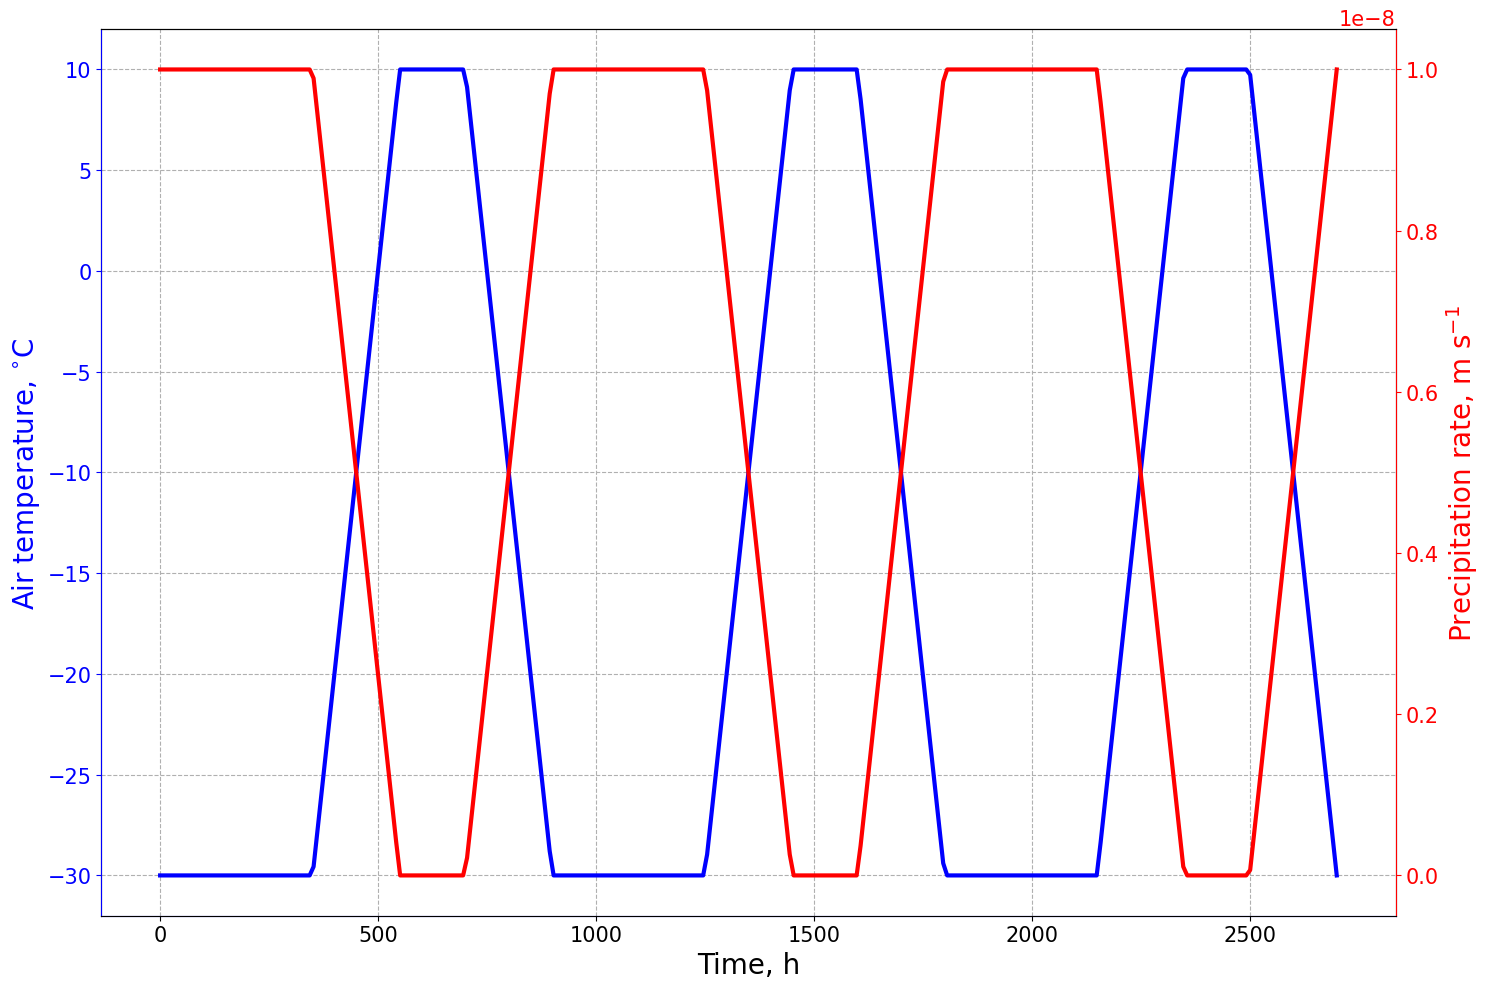

In [9]:
time_arr = np.linspace(0, 3*year_time, 300)

fig, ax1 = plt.subplots(figsize=(15, 10))
# ax1.set_title('Temperature and precipitation evolution', size=25)
ax2 = ax1.twinx()
ax1.plot(time_arr/3600.0,
         [linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                          lowest_temp, highest_temp,
                          lowest_p, highest_p, t)[0] for t in time_arr],
         label='tempreature', color='b', lw=3)
ax2.plot(time_arr/3600.0,
         [linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                          lowest_temp, highest_temp,
                          lowest_p, highest_p, t)[1] for t in time_arr],
         label='precipitation', color='r', lw=3)
ax1.spines['bottom'].set_color('b')
ax1.set_xlabel('Time, h', size=20)
ax1.set_ylabel(r'Air temperature, $^{\circ}$C', size=20)
ax2.set_ylabel(r'Precipitation rate, m s$^{-1}$', size=20)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.spines['left'].set_color('b')
ax1.tick_params(axis='y', colors='b')
ax1.yaxis.label.set_color('b')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax2.yaxis.offsetText.set_fontsize(15)
ax1.grid(ls='--')
fig.tight_layout()
fig.savefig('media/prec_temp.png', dpi=200)
plt.show()

In [10]:
def multiyear_evolution_0d(time_step,
                           N_pseudoiter=50,
                           n_years=1):
    
    # форсинг
    winter_time = 350*3600.0
    spring_time = 200*3600.0
    summer_time = 150*3600.0
    autumn_time = 200*3600.0
    year_time = winter_time + spring_time + summer_time + autumn_time
    
    lowest_temp = -30.0
    highest_temp = 10.0
    lowest_p = 0.0
    highest_p = 1e-7
    
    Ta = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                      lowest_temp, highest_temp,
                                      lowest_p, highest_p, time)[0]
    
    p = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                     lowest_temp, highest_temp,
                                     lowest_p, highest_p, time)[1]
    
    Toi = lambda time: ue.Tf_i(30.0)
    
    F_ocn = lambda T, time: 0.0
    F_atm = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(Ta(time) - T)
    
    # инициализация процесса
    Tis_init = -15.0
    Tsa_init = -20.0
    
    ice_thickness_init = 4.0
    snow_thickness_init = 0.1
    
    process = ue0d.main_process_0d(time_step=time_step,
                                   time_end=year_time*n_years,
                                   N_pseudoiter=N_pseudoiter,
                                   Tis_init=Tis_init,
                                   Tsa_init=Tsa_init,
                                   ice_thickness_init=ice_thickness_init,
                                   snow_thickness_init=snow_thickness_init,
                                   snow_thickness_threshold=0.05,
                                   Toi=Toi,
                                   Ta=Ta,
                                   p=p,
                                   F_atm_ice=F_atm,
                                   F_atm_snow=F_atm,
                                   F_ocn=F_ocn)
    
    return process

In [11]:
def multiyear_evolution_1d(N_cells_ice,
                           N_cells_snow,
                           time_step,
                           N_pseudoiter=50,
                           n_years=1):
    
    # форсинг
    winter_time = 350*3600.0
    spring_time = 200*3600.0
    summer_time = 150*3600.0
    autumn_time = 200*3600.0
    year_time = winter_time + spring_time + summer_time + autumn_time
    
    lowest_temp = -30.0
    highest_temp = 10.0
    lowest_p = 0.0
    highest_p = 1e-7
    
    Ta = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                      lowest_temp, highest_temp,
                                      lowest_p, highest_p, time)[0]
    
    p = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                     lowest_temp, highest_temp,
                                     lowest_p, highest_p, time)[1]
    
    Toi = lambda time: ue.Tf_i(30.0)
    
    F_ocn = lambda T, time: 0.0
    F_atm = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(Ta(time) - T)
    
    # инициализация процесса
    Tis_init = -15.0
    Tsa_init = -20.0
    
    ice_thickness_init = 4.0
    snow_thickness_init = 0.1
    
    dzi_init = np.full(N_cells_ice, ice_thickness_init/N_cells_ice)
    dzs_init = np.full(N_cells_snow, snow_thickness_init/N_cells_snow)
    salinity_init = np.linspace(4.0, 1.0, N_cells_ice)
    Ti_init = Toi(0.0) + np.arange(0.5, N_cells_ice)/N_cells_ice * (Tis_init - Toi(0.0))
    Ts_init = Tis_init + np.arange(0.5, N_cells_snow)/N_cells_snow * (Tsa_init - Tis_init)
    
    process = ue.main_process(time_step=time_step,
                              time_end=year_time*n_years,
                              N_pseudoiter=N_pseudoiter,
                              Ti_init=Ti_init,
                              Ts_init=Ts_init,
                              Tis_init=Tis_init,
                              Tsa_init=Tsa_init,
                              dzi_init=dzi_init,
                              dzs_init=dzs_init,
                              salinity=salinity_init,
                              snow_thickness_threshold=0.05,
                              Toi=Toi,
                              Ta=Ta,
                              p=p,
                              F_atm_ice=F_atm,
                              F_atm_snow=F_atm,
                              F_sw=lambda time: 0.0,
                              F_ocn=F_ocn)
    
    return process

In [12]:
# расчет моделей
test_process_0d = multiyear_evolution_0d(time_step=3600.0,
                                         n_years=3)

test_process_1d = multiyear_evolution_1d(N_cells_ice=10,
                                         N_cells_snow=5,
                                         time_step=3600.0,
                                         n_years=3)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 277.0 h.: Snow-ice freezing...
Time 278.0 h.: Snow-ice freezing...
Time 279.0 h.: Snow-ice freezing...
Time 280.0 h.: Snow-ice freezing...
Time 281.0 h.: Snow-ice freezing...
Time 282.0 h.: Snow-ice freezing...
Time 283.0 h.: Snow-ice freezing...
Time 284.0 h.: Snow-ice freezing...
Time 285.0 h.: Snow-ice freezing...
Time 286.0 h.: Snow-ice freezing...
Time 287.0 h.: Snow-ice freezing...
Time 288.0 h.: Snow-ice freezing...
Time 289.0 h.: Snow-ice freezing...
Time 290.0 h.: Snow-ice freezing...
Time 291.0 h.: Snow-ice freezing...
Time 292.0 h.: Snow-ice freezing...
Time 293.0 h.: Snow-ice freezing...
Time 294.0 h.: Snow-ice freezing...
Time 295.0 h.: Snow-ice freezing...
Time 296.0 h.: Snow-ice freezing...
Time 297.0 h.: Snow-ice freezing...
Time 298.0 h.: Snow-ice freezing...
Time 299.0 h.: Snow-ice freezing...
Time 300.0 h.: Snow-ice freezing...
Time 301.0 h.: Snow-ice freezing...
Time 302.0 h.: Snow-ice freezing...
Time 303.0 h.: Snow-ice freezing...
Time 304.0 h.: Snow-ice free

Time 530.0 h.: Snow-ice freezing...
Time 530.0 h.: Snow-ice melting...
Time 531.0 h.: Snow-ice freezing...
Time 531.0 h.: Snow-ice melting...
Time 532.0 h.: Snow-ice freezing...
Time 532.0 h.: Snow-ice melting...
Time 533.0 h.: Snow-ice freezing...
Time 533.0 h.: Snow-ice melting...
Time 534.0 h.: Snow-ice freezing...
Time 534.0 h.: Snow-ice melting...
Time 535.0 h.: Snow-ice freezing...
Time 535.0 h.: Snow-ice melting...
Time 536.0 h.: Snow-ice freezing...
Time 536.0 h.: Snow-ice melting...
Time 537.0 h.: Snow-ice freezing...
Time 537.0 h.: Snow-ice melting...
Time 538.0 h.: Snow-ice freezing...
Time 538.0 h.: Snow-ice melting...
Time 539.0 h.: Snow-ice freezing...
Time 539.0 h.: Snow-ice melting...
Time 540.0 h.: Snow-ice freezing...
Time 540.0 h.: Snow-ice melting...
Time 541.0 h.: Snow-ice freezing...
Time 541.0 h.: Snow-ice melting...
Time 542.0 h.: Snow-ice freezing...
Time 542.0 h.: Snow-ice melting...
Time 543.0 h.: Snow-ice freezing...
Time 543.0 h.: Snow-ice melting...
Time 5

Time 800.0 h.: Snow-ice freezing...
Time 801.0 h.: Snow-ice freezing...
Time 802.0 h.: Snow-ice freezing...
Time 803.0 h.: Snow-ice freezing...
Time 804.0 h.: Snow-ice freezing...
Time 805.0 h.: Snow-ice freezing...
Time 806.0 h.: Snow-ice freezing...
Time 807.0 h.: Snow-ice freezing...
Time 808.0 h.: Snow-ice freezing...
Time 809.0 h.: Snow-ice freezing...
Time 810.0 h.: Snow-ice freezing...
Time 811.0 h.: Snow-ice freezing...
Time 812.0 h.: Snow-ice freezing...
Time 813.0 h.: Snow-ice freezing...
Time 814.0 h.: Snow-ice freezing...
Time 815.0 h.: Snow-ice freezing...
Time 816.0 h.: Snow-ice freezing...
Time 817.0 h.: Snow-ice freezing...
Time 818.0 h.: Snow-ice freezing...
Time 819.0 h.: Snow-ice freezing...
Time 820.0 h.: Snow-ice freezing...
Time 821.0 h.: Snow-ice freezing...
Time 822.0 h.: Snow-ice freezing...
Time 823.0 h.: Snow-ice freezing...
Time 824.0 h.: Snow-ice freezing...
Time 825.0 h.: Snow-ice freezing...
Time 826.0 h.: Snow-ice freezing...
Time 827.0 h.: Snow-ice free

Time 1303.0 h.: Snow-ice freezing...
Time 1304.0 h.: Snow-ice freezing...
Time 1305.0 h.: Snow-ice freezing...
Time 1306.0 h.: Snow-ice freezing...
Time 1307.0 h.: Snow-ice freezing...
Time 1308.0 h.: Snow-ice freezing...
Time 1309.0 h.: Snow-ice freezing...
Time 1310.0 h.: Snow-ice freezing...
Time 1311.0 h.: Snow-ice freezing...
Time 1312.0 h.: Snow-ice freezing...
Time 1313.0 h.: Snow-ice freezing...
Time 1314.0 h.: Snow-ice freezing...
Time 1315.0 h.: Snow-ice freezing...
Time 1316.0 h.: Snow-ice freezing...
Time 1317.0 h.: Snow-ice freezing...
Time 1318.0 h.: Snow-ice freezing...
Time 1319.0 h.: Snow-ice freezing...
Time 1320.0 h.: Snow-ice freezing...
Time 1321.0 h.: Snow-ice freezing...
Time 1322.0 h.: Snow-ice freezing...
Time 1323.0 h.: Snow-ice freezing...
Time 1324.0 h.: Snow-ice freezing...
Time 1325.0 h.: Snow-ice freezing...
Time 1326.0 h.: Snow-ice freezing...
Time 1327.0 h.: Snow-ice freezing...
Time 1328.0 h.: Snow-ice freezing...
Time 1329.0 h.: Snow-ice freezing...
T

Time 1711.0 h.: Snow-ice freezing...
Time 1712.0 h.: Snow-ice freezing...
Time 1713.0 h.: Snow-ice freezing...
Time 1714.0 h.: Snow-ice freezing...
Time 1715.0 h.: Snow-ice freezing...
Time 1716.0 h.: Snow-ice freezing...
Time 1717.0 h.: Snow-ice freezing...
Time 1718.0 h.: Snow-ice freezing...
Time 1719.0 h.: Snow-ice freezing...
Time 1720.0 h.: Snow-ice freezing...
Time 1721.0 h.: Snow-ice freezing...
Time 1722.0 h.: Snow-ice freezing...
Time 1723.0 h.: Snow-ice freezing...
Time 1724.0 h.: Snow-ice freezing...
Time 1725.0 h.: Snow-ice freezing...
Time 1726.0 h.: Snow-ice freezing...
Time 1727.0 h.: Snow-ice freezing...
Time 1728.0 h.: Snow-ice freezing...
Time 1729.0 h.: Snow-ice freezing...
Time 1730.0 h.: Snow-ice freezing...
Time 1731.0 h.: Snow-ice freezing...
Time 1732.0 h.: Snow-ice freezing...
Time 1733.0 h.: Snow-ice freezing...
Time 1734.0 h.: Snow-ice freezing...
Time 1735.0 h.: Snow-ice freezing...
Time 1736.0 h.: Snow-ice freezing...
Time 1737.0 h.: Snow-ice freezing...
T

Time 2028.0 h.: Snow-ice freezing...
Time 2029.0 h.: Snow-ice freezing...
Time 2030.0 h.: Snow-ice freezing...
Time 2031.0 h.: Snow-ice freezing...
Time 2032.0 h.: Snow-ice freezing...
Time 2033.0 h.: Snow-ice freezing...
Time 2034.0 h.: Snow-ice freezing...
Time 2035.0 h.: Snow-ice freezing...
Time 2036.0 h.: Snow-ice freezing...
Time 2037.0 h.: Snow-ice freezing...
Time 2038.0 h.: Snow-ice freezing...
Time 2039.0 h.: Snow-ice freezing...
Time 2040.0 h.: Snow-ice freezing...
Time 2041.0 h.: Snow-ice freezing...
Time 2042.0 h.: Snow-ice freezing...
Time 2043.0 h.: Snow-ice freezing...
Time 2044.0 h.: Snow-ice freezing...
Time 2045.0 h.: Snow-ice freezing...
Time 2046.0 h.: Snow-ice freezing...
Time 2047.0 h.: Snow-ice freezing...
Time 2048.0 h.: Snow-ice freezing...
Time 2049.0 h.: Snow-ice freezing...
Time 2050.0 h.: Snow-ice freezing...
Time 2051.0 h.: Snow-ice freezing...
Time 2052.0 h.: Snow-ice freezing...
Time 2053.0 h.: Snow-ice freezing...
Time 2054.0 h.: Snow-ice freezing...
T

Time 2269.0 h.: Snow-ice freezing...
Time 2270.0 h.: Snow-ice freezing...
Time 2271.0 h.: Snow-ice freezing...
Time 2272.0 h.: Snow-ice freezing...
Time 2273.0 h.: Snow-ice freezing...
Time 2274.0 h.: Snow-ice freezing...
Time 2275.0 h.: Snow-ice freezing...
Time 2276.0 h.: Snow-ice freezing...
Time 2277.0 h.: Snow-ice freezing...
Time 2278.0 h.: Snow-ice freezing...
Time 2279.0 h.: Snow-ice freezing...
Time 2280.0 h.: Snow-ice freezing...
Time 2281.0 h.: Snow-ice freezing...
Time 2282.0 h.: Snow-ice freezing...
Time 2283.0 h.: Snow-ice freezing...
Time 2284.0 h.: Snow-ice freezing...
Time 2285.0 h.: Snow-ice freezing...
Time 2286.0 h.: Snow-ice freezing...
Time 2287.0 h.: Snow-ice freezing...
Time 2288.0 h.: Snow-ice freezing...
Time 2289.0 h.: Snow-ice freezing...
Time 2290.0 h.: Snow-ice freezing...
Time 2291.0 h.: Snow-ice freezing...
Time 2292.0 h.: Snow-ice freezing...
Time 2293.0 h.: Snow-ice freezing...
Time 2294.0 h.: Snow-ice freezing...
Time 2295.0 h.: Snow-ice freezing...
T

Time 2570.0 h.: Snow-ice freezing...
Time 2571.0 h.: Snow-ice freezing...
Time 2572.0 h.: Snow-ice freezing...
Time 2573.0 h.: Snow-ice freezing...
Time 2574.0 h.: Snow-ice freezing...
Time 2575.0 h.: Snow-ice freezing...
Time 2576.0 h.: Snow-ice freezing...
Time 2577.0 h.: Snow-ice freezing...
Time 2578.0 h.: Snow-ice freezing...
Time 2579.0 h.: Snow-ice freezing...
Time 2580.0 h.: Snow-ice freezing...
Time 2581.0 h.: Snow-ice freezing...
Time 2582.0 h.: Snow-ice freezing...
Time 2583.0 h.: Snow-ice freezing...
Time 2584.0 h.: Snow-ice freezing...
Time 2585.0 h.: Snow-ice freezing...
Time 2586.0 h.: Snow-ice freezing...
Time 2587.0 h.: Snow-ice freezing...
Time 2588.0 h.: Snow-ice freezing...
Time 2589.0 h.: Snow-ice freezing...
Time 2590.0 h.: Snow-ice freezing...
Time 2591.0 h.: Snow-ice freezing...
Time 2592.0 h.: Snow-ice freezing...
Time 2593.0 h.: Snow-ice freezing...
Time 2594.0 h.: Snow-ice freezing...
Time 2595.0 h.: Snow-ice freezing...
Time 2596.0 h.: Snow-ice freezing...
T

Time 97.0 h.: Snow-ice freezing...
Time 98.0 h.: Snow-ice freezing...
Time 99.0 h.: Snow-ice freezing...
Time 100.0 h.: Snow-ice freezing...
Time 101.0 h.: Snow-ice freezing...
Time 102.0 h.: Snow-ice freezing...
Time 103.0 h.: Snow-ice freezing...
Time 104.0 h.: Snow-ice freezing...
Time 105.0 h.: Snow-ice freezing...
Time 106.0 h.: Snow-ice freezing...
Time 107.0 h.: Snow-ice freezing...
Time 108.0 h.: Snow-ice freezing...
Time 109.0 h.: Snow-ice freezing...
Time 110.0 h.: Snow-ice freezing...
Time 111.0 h.: Snow-ice freezing...
Time 112.0 h.: Snow-ice freezing...
Time 113.0 h.: Snow-ice freezing...
Time 114.0 h.: Snow-ice freezing...
Time 115.0 h.: Snow-ice freezing...
Time 116.0 h.: Snow-ice freezing...
Time 117.0 h.: Snow-ice freezing...
Time 118.0 h.: Snow-ice freezing...
Time 119.0 h.: Snow-ice freezing...
Time 120.0 h.: Snow-ice freezing...
Time 121.0 h.: Snow-ice freezing...
Time 122.0 h.: Snow-ice freezing...
Time 123.0 h.: Snow-ice freezing...
Time 124.0 h.: Snow-ice freezin

Time 328.0 h.: Snow-ice freezing...
Time 329.0 h.: Snow-ice freezing...
Time 330.0 h.: Snow-ice freezing...
Time 331.0 h.: Snow-ice freezing...
Time 332.0 h.: Snow-ice freezing...
Time 333.0 h.: Snow-ice freezing...
Time 334.0 h.: Snow-ice freezing...
Time 335.0 h.: Snow-ice freezing...
Time 336.0 h.: Snow-ice freezing...
Time 337.0 h.: Snow-ice freezing...
Time 338.0 h.: Snow-ice freezing...
Time 339.0 h.: Snow-ice freezing...
Time 340.0 h.: Snow-ice freezing...
Time 341.0 h.: Snow-ice freezing...
Time 342.0 h.: Snow-ice freezing...
Time 343.0 h.: Snow-ice freezing...
Time 344.0 h.: Snow-ice freezing...
Time 345.0 h.: Snow-ice freezing...
Time 346.0 h.: Snow-ice freezing...
Time 347.0 h.: Snow-ice freezing...
Time 348.0 h.: Snow-ice freezing...
Time 349.0 h.: Snow-ice freezing...
Time 350.0 h.: Snow-ice freezing...
Time 351.0 h.: Snow-ice freezing...
Time 352.0 h.: Snow-ice freezing...
Time 353.0 h.: Snow-ice freezing...
Time 354.0 h.: Snow-ice freezing...
Time 355.0 h.: Snow-ice free

Time 532.0 h.: Snow-ice melting...
Time 533.0 h.: Snow-ice freezing...
Time 533.0 h.: Snow-ice melting...
Time 534.0 h.: Snow-ice freezing...
Time 534.0 h.: Snow-ice melting...
Time 535.0 h.: Snow-ice freezing...
Time 535.0 h.: Snow-ice melting...
Time 536.0 h.: Snow-ice freezing...
Time 536.0 h.: Snow-ice melting...
Time 537.0 h.: Snow-ice freezing...
Time 537.0 h.: Snow-ice melting...
Time 538.0 h.: Snow-ice freezing...
Time 538.0 h.: Snow-ice melting...
Time 539.0 h.: Snow-ice freezing...
Time 539.0 h.: Snow-ice melting...
Time 540.0 h.: Snow-ice freezing...
Time 540.0 h.: Snow-ice melting...
Time 541.0 h.: Snow-ice freezing...
Time 541.0 h.: Snow-ice melting...
Time 542.0 h.: Snow-ice freezing...
Time 542.0 h.: Snow-ice melting...
Time 543.0 h.: Snow-ice freezing...
Time 543.0 h.: Snow-ice melting...
Time 544.0 h.: Snow-ice freezing...
Time 544.0 h.: Snow-ice melting...
Time 545.0 h.: Snow-ice freezing...
Time 545.0 h.: Snow-ice melting...
Time 546.0 h.: Snow-ice freezing...
Time 5

Time 654.0 h.: Ice freezing...
Time 654.0 h.: Ice melting...
Time 655.0 h.: Ice freezing...
Time 655.0 h.: Ice melting...
Time 656.0 h.: Ice freezing...
Time 656.0 h.: Ice melting...
Time 657.0 h.: Ice freezing...
Time 657.0 h.: Ice melting...
Time 658.0 h.: Ice freezing...
Time 658.0 h.: Ice melting...
Time 659.0 h.: Ice freezing...
Time 659.0 h.: Ice melting...
Time 660.0 h.: Ice freezing...
Time 660.0 h.: Ice melting...
Time 661.0 h.: Ice freezing...
Time 661.0 h.: Ice melting...
Time 662.0 h.: Ice freezing...
Time 662.0 h.: Ice melting...
Time 663.0 h.: Ice freezing...
Time 663.0 h.: Ice melting...
Time 664.0 h.: Ice freezing...
Time 664.0 h.: Ice melting...
Time 665.0 h.: Ice freezing...
Time 665.0 h.: Ice melting...
Time 666.0 h.: Ice freezing...
Time 666.0 h.: Ice melting...
Time 667.0 h.: Ice freezing...
Time 667.0 h.: Ice melting...
Time 668.0 h.: Ice freezing...
Time 668.0 h.: Ice melting...
Time 669.0 h.: Ice freezing...
Time 669.0 h.: Ice melting...
Time 670.0 h.: Ice freez

Time 822.0 h.: Snow-ice freezing...
Time 823.0 h.: Snow-ice freezing...
Time 824.0 h.: Snow-ice freezing...
Time 825.0 h.: Snow-ice freezing...
Time 826.0 h.: Snow-ice freezing...
Time 827.0 h.: Snow-ice freezing...
Time 828.0 h.: Snow-ice freezing...
Time 829.0 h.: Snow-ice freezing...
Time 830.0 h.: Snow-ice freezing...
Time 831.0 h.: Snow-ice freezing...
Time 832.0 h.: Snow-ice freezing...
Time 833.0 h.: Snow-ice freezing...
Time 834.0 h.: Snow-ice freezing...
Time 835.0 h.: Snow-ice freezing...
Time 836.0 h.: Snow-ice freezing...
Time 837.0 h.: Snow-ice freezing...
Time 838.0 h.: Snow-ice freezing...
Time 839.0 h.: Snow-ice freezing...
Time 840.0 h.: Snow-ice freezing...
Time 841.0 h.: Snow-ice freezing...
Time 842.0 h.: Snow-ice freezing...
Time 843.0 h.: Snow-ice freezing...
Time 844.0 h.: Snow-ice freezing...
Time 845.0 h.: Snow-ice freezing...
Time 846.0 h.: Snow-ice freezing...
Time 847.0 h.: Snow-ice freezing...
Time 848.0 h.: Snow-ice freezing...
Time 849.0 h.: Snow-ice free

Time 1050.0 h.: Snow-ice freezing...
Time 1051.0 h.: Snow-ice freezing...
Time 1052.0 h.: Snow-ice freezing...
Time 1053.0 h.: Snow-ice freezing...
Time 1054.0 h.: Snow-ice freezing...
Time 1055.0 h.: Snow-ice freezing...
Time 1056.0 h.: Snow-ice freezing...
Time 1057.0 h.: Snow-ice freezing...
Time 1058.0 h.: Snow-ice freezing...
Time 1059.0 h.: Snow-ice freezing...
Time 1060.0 h.: Snow-ice freezing...
Time 1061.0 h.: Snow-ice freezing...
Time 1062.0 h.: Snow-ice freezing...
Time 1063.0 h.: Snow-ice freezing...
Time 1064.0 h.: Snow-ice freezing...
Time 1065.0 h.: Snow-ice freezing...
Time 1066.0 h.: Snow-ice freezing...
Time 1067.0 h.: Snow-ice freezing...
Time 1068.0 h.: Snow-ice freezing...
Time 1069.0 h.: Snow-ice freezing...
Time 1070.0 h.: Snow-ice freezing...
Time 1071.0 h.: Snow-ice freezing...
Time 1072.0 h.: Snow-ice freezing...
Time 1073.0 h.: Snow-ice freezing...
Time 1074.0 h.: Snow-ice freezing...
Time 1075.0 h.: Snow-ice freezing...
Time 1076.0 h.: Snow-ice freezing...
T

Time 1278.0 h.: Snow-ice freezing...
Time 1279.0 h.: Snow-ice freezing...
Time 1280.0 h.: Snow-ice freezing...
Time 1281.0 h.: Snow-ice freezing...
Time 1282.0 h.: Snow-ice freezing...
Time 1283.0 h.: Snow-ice freezing...
Time 1284.0 h.: Snow-ice freezing...
Time 1285.0 h.: Snow-ice freezing...
Time 1286.0 h.: Snow-ice freezing...
Time 1287.0 h.: Snow-ice freezing...
Time 1288.0 h.: Snow-ice freezing...
Time 1289.0 h.: Snow-ice freezing...
Time 1290.0 h.: Snow-ice freezing...
Time 1291.0 h.: Snow-ice freezing...
Time 1292.0 h.: Snow-ice freezing...
Time 1293.0 h.: Snow-ice freezing...
Time 1294.0 h.: Snow-ice freezing...
Time 1295.0 h.: Snow-ice freezing...
Time 1296.0 h.: Snow-ice freezing...
Time 1297.0 h.: Snow-ice freezing...
Time 1298.0 h.: Snow-ice freezing...
Time 1299.0 h.: Snow-ice freezing...
Time 1300.0 h.: Snow-ice freezing...
Time 1301.0 h.: Snow-ice freezing...
Time 1302.0 h.: Snow-ice freezing...
Time 1303.0 h.: Snow-ice freezing...
Time 1304.0 h.: Snow-ice freezing...
T

Time 1454.0 h.: Snow-ice freezing...
Time 1454.0 h.: Snow-ice melting...
Time 1455.0 h.: Snow-ice freezing...
Time 1455.0 h.: Snow-ice melting...
Time 1456.0 h.: Snow-ice freezing...
Time 1456.0 h.: Snow-ice melting...
Time 1457.0 h.: Snow-ice freezing...
Time 1457.0 h.: Snow-ice melting...
Time 1458.0 h.: Snow-ice freezing...
Time 1458.0 h.: Snow-ice melting...
Time 1459.0 h.: Snow-ice freezing...
Time 1459.0 h.: Snow-ice melting...
Time 1460.0 h.: Snow-ice freezing...
Time 1460.0 h.: Snow-ice melting...
Time 1461.0 h.: Snow-ice freezing...
Time 1461.0 h.: Snow-ice melting...
Time 1462.0 h.: Snow-ice freezing...
Time 1462.0 h.: Snow-ice melting...
Time 1463.0 h.: Snow-ice freezing...
Time 1463.0 h.: Snow-ice melting...
Time 1464.0 h.: Snow-ice freezing...
Time 1464.0 h.: Snow-ice melting...
Time 1465.0 h.: Snow-ice freezing...
Time 1465.0 h.: Snow-ice melting...
Time 1466.0 h.: Snow-ice freezing...
Time 1466.0 h.: Snow-ice melting...
Time 1467.0 h.: Snow-ice freezing...
Time 1467.0 h.

Time 1575.0 h.: Ice freezing...
Time 1575.0 h.: Ice melting...
Time 1576.0 h.: Ice freezing...
Time 1576.0 h.: Ice melting...
Time 1577.0 h.: Ice freezing...
Time 1577.0 h.: Ice melting...
Time 1578.0 h.: Ice freezing...
Time 1578.0 h.: Ice melting...
Time 1579.0 h.: Ice freezing...
Time 1579.0 h.: Ice melting...
Time 1580.0 h.: Ice freezing...
Time 1580.0 h.: Ice melting...
Time 1581.0 h.: Ice freezing...
Time 1581.0 h.: Ice melting...
Time 1582.0 h.: Ice freezing...
Time 1582.0 h.: Ice melting...
Time 1583.0 h.: Ice freezing...
Time 1583.0 h.: Ice melting...
Time 1584.0 h.: Ice freezing...
Time 1584.0 h.: Ice melting...
Time 1585.0 h.: Ice freezing...
Time 1585.0 h.: Ice melting...
Time 1586.0 h.: Ice freezing...
Time 1586.0 h.: Ice melting...
Time 1587.0 h.: Ice freezing...
Time 1587.0 h.: Ice melting...
Time 1588.0 h.: Ice freezing...
Time 1588.0 h.: Ice melting...
Time 1589.0 h.: Ice freezing...
Time 1589.0 h.: Ice melting...
Time 1590.0 h.: Ice freezing...
Time 1590.0 h.: Ice mel

Time 1754.0 h.: Snow-ice freezing...
Time 1755.0 h.: Snow-ice freezing...
Time 1756.0 h.: Snow-ice freezing...
Time 1757.0 h.: Snow-ice freezing...
Time 1758.0 h.: Snow-ice freezing...
Time 1759.0 h.: Snow-ice freezing...
Time 1760.0 h.: Snow-ice freezing...
Time 1761.0 h.: Snow-ice freezing...
Time 1762.0 h.: Snow-ice freezing...
Time 1763.0 h.: Snow-ice freezing...
Time 1764.0 h.: Snow-ice freezing...
Time 1765.0 h.: Snow-ice freezing...
Time 1766.0 h.: Snow-ice freezing...
Time 1767.0 h.: Snow-ice freezing...
Time 1768.0 h.: Snow-ice freezing...
Time 1769.0 h.: Snow-ice freezing...
Time 1770.0 h.: Snow-ice freezing...
Time 1771.0 h.: Snow-ice freezing...
Time 1772.0 h.: Snow-ice freezing...
Time 1773.0 h.: Snow-ice freezing...
Time 1774.0 h.: Snow-ice freezing...
Time 1775.0 h.: Snow-ice freezing...
Time 1776.0 h.: Snow-ice freezing...
Time 1777.0 h.: Snow-ice freezing...
Time 1778.0 h.: Snow-ice freezing...
Time 1779.0 h.: Snow-ice freezing...
Time 1780.0 h.: Snow-ice freezing...
T

Time 1981.0 h.: Snow-ice freezing...
Time 1982.0 h.: Snow-ice freezing...
Time 1983.0 h.: Snow-ice freezing...
Time 1984.0 h.: Snow-ice freezing...
Time 1985.0 h.: Snow-ice freezing...
Time 1986.0 h.: Snow-ice freezing...
Time 1987.0 h.: Snow-ice freezing...
Time 1988.0 h.: Snow-ice freezing...
Time 1989.0 h.: Snow-ice freezing...
Time 1990.0 h.: Snow-ice freezing...
Time 1991.0 h.: Snow-ice freezing...
Time 1992.0 h.: Snow-ice freezing...
Time 1993.0 h.: Snow-ice freezing...
Time 1994.0 h.: Snow-ice freezing...
Time 1995.0 h.: Snow-ice freezing...
Time 1996.0 h.: Snow-ice freezing...
Time 1997.0 h.: Snow-ice freezing...
Time 1998.0 h.: Snow-ice freezing...
Time 1999.0 h.: Snow-ice freezing...
Time 2000.0 h.: Snow-ice freezing...
Time 2001.0 h.: Snow-ice freezing...
Time 2002.0 h.: Snow-ice freezing...
Time 2003.0 h.: Snow-ice freezing...
Time 2004.0 h.: Snow-ice freezing...
Time 2005.0 h.: Snow-ice freezing...
Time 2006.0 h.: Snow-ice freezing...
Time 2007.0 h.: Snow-ice freezing...
T

Time 2207.0 h.: Snow-ice freezing...
Time 2208.0 h.: Snow-ice freezing...
Time 2209.0 h.: Snow-ice freezing...
Time 2210.0 h.: Snow-ice freezing...
Time 2211.0 h.: Snow-ice freezing...
Time 2212.0 h.: Snow-ice freezing...
Time 2213.0 h.: Snow-ice freezing...
Time 2214.0 h.: Snow-ice freezing...
Time 2215.0 h.: Snow-ice freezing...
Time 2216.0 h.: Snow-ice freezing...
Time 2217.0 h.: Snow-ice freezing...
Time 2218.0 h.: Snow-ice freezing...
Time 2219.0 h.: Snow-ice freezing...
Time 2220.0 h.: Snow-ice freezing...
Time 2221.0 h.: Snow-ice freezing...
Time 2222.0 h.: Snow-ice freezing...
Time 2223.0 h.: Snow-ice freezing...
Time 2224.0 h.: Snow-ice freezing...
Time 2225.0 h.: Snow-ice freezing...
Time 2226.0 h.: Snow-ice freezing...
Time 2227.0 h.: Snow-ice freezing...
Time 2228.0 h.: Snow-ice freezing...
Time 2229.0 h.: Snow-ice freezing...
Time 2230.0 h.: Snow-ice freezing...
Time 2231.0 h.: Snow-ice freezing...
Time 2232.0 h.: Snow-ice freezing...
Time 2233.0 h.: Snow-ice freezing...
T

Time 2369.0 h.: Snow-ice freezing...
Time 2369.0 h.: Snow-ice melting...
Time 2370.0 h.: Snow-ice freezing...
Time 2370.0 h.: Snow-ice melting...
Time 2371.0 h.: Snow-ice freezing...
Time 2371.0 h.: Snow-ice melting...
Time 2372.0 h.: Snow-ice freezing...
Time 2372.0 h.: Snow-ice melting...
Time 2373.0 h.: Snow-ice freezing...
Time 2373.0 h.: Snow-ice melting...
Time 2374.0 h.: Snow-ice freezing...
Time 2374.0 h.: Snow-ice melting...
Time 2375.0 h.: Snow-ice freezing...
Time 2375.0 h.: Snow-ice melting...
Time 2376.0 h.: Snow-ice freezing...
Time 2376.0 h.: Snow-ice melting...
Time 2377.0 h.: Snow-ice freezing...
Time 2377.0 h.: Snow-ice melting...
Time 2378.0 h.: Snow-ice freezing...
Time 2378.0 h.: Snow-ice melting...
Time 2379.0 h.: Snow-ice freezing...
Time 2379.0 h.: Snow-ice melting...
Time 2380.0 h.: Snow-ice freezing...
Time 2380.0 h.: Snow-ice melting...
Time 2381.0 h.: Snow-ice freezing...
Time 2381.0 h.: Snow-ice melting...
Time 2382.0 h.: Snow-ice freezing...
Time 2382.0 h.

Time 2493.0 h.: Ice melting...
Time 2494.0 h.: Ice freezing...
Time 2494.0 h.: Ice melting...
Time 2495.0 h.: Ice freezing...
Time 2495.0 h.: Ice melting...
Time 2496.0 h.: Ice freezing...
Time 2496.0 h.: Ice melting...
Time 2497.0 h.: Ice freezing...
Time 2497.0 h.: Ice melting...
Time 2498.0 h.: Ice freezing...
Time 2498.0 h.: Ice melting...
Time 2499.0 h.: Ice freezing...
Time 2499.0 h.: Ice melting...
Time 2500.0 h.: Ice freezing...
Time 2500.0 h.: Ice melting...
Time 2501.0 h.: Ice freezing...
Time 2501.0 h.: Ice melting...
Time 2502.0 h.: Ice freezing...
Time 2502.0 h.: Ice melting...
Time 2503.0 h.: Ice freezing...
Time 2503.0 h.: Ice melting...
Time 2504.0 h.: Ice freezing...
Time 2504.0 h.: Ice melting...
Time 2505.0 h.: Ice freezing...
Time 2505.0 h.: Ice melting...
Time 2506.0 h.: Ice freezing...
Time 2506.0 h.: Ice melting...
Time 2507.0 h.: Ice freezing...
Time 2507.0 h.: Ice melting...
Time 2508.0 h.: Ice freezing...
Time 2508.0 h.: Ice melting...
Time 2509.0 h.: Ice free

Time 2687.0 h.: Snow-ice freezing...
Time 2688.0 h.: Snow-ice freezing...
Time 2689.0 h.: Snow-ice freezing...
Time 2690.0 h.: Snow-ice freezing...
Time 2691.0 h.: Snow-ice freezing...
Time 2692.0 h.: Snow-ice freezing...
Time 2693.0 h.: Snow-ice freezing...
Time 2694.0 h.: Snow-ice freezing...
Time 2695.0 h.: Snow-ice freezing...
Time 2696.0 h.: Snow-ice freezing...
Time 2697.0 h.: Snow-ice freezing...
Time 2698.0 h.: Snow-ice freezing...
Time 2699.0 h.: Snow-ice freezing...
Time 2700.0 h.: Snow-ice freezing...


In [ ]:
uv.animate([test_process_0d, test_process_1d], names=['0D','1D'])

In [ ]:
# test_process_0d.timeline /= 3600*24
# test_process_1d.timeline /= 3600*24

In [ ]:
uv.timeseries_err(process_sim=test_process_1d,
                  process_data=test_process_0d,
                  label_sim='1-D', label_data='0-D', legend_loc='lower right',
                  tmin_err=-15., tmax_err=15., step_err=1.0,
                  levels_border = [-10, -5, -2, -1, 1, 2, 5, 10],
                  figsize=(20, 10), savepath='media/model_temp_diff.png')

In [16]:
test_process_0d.timeline /= 3600*24

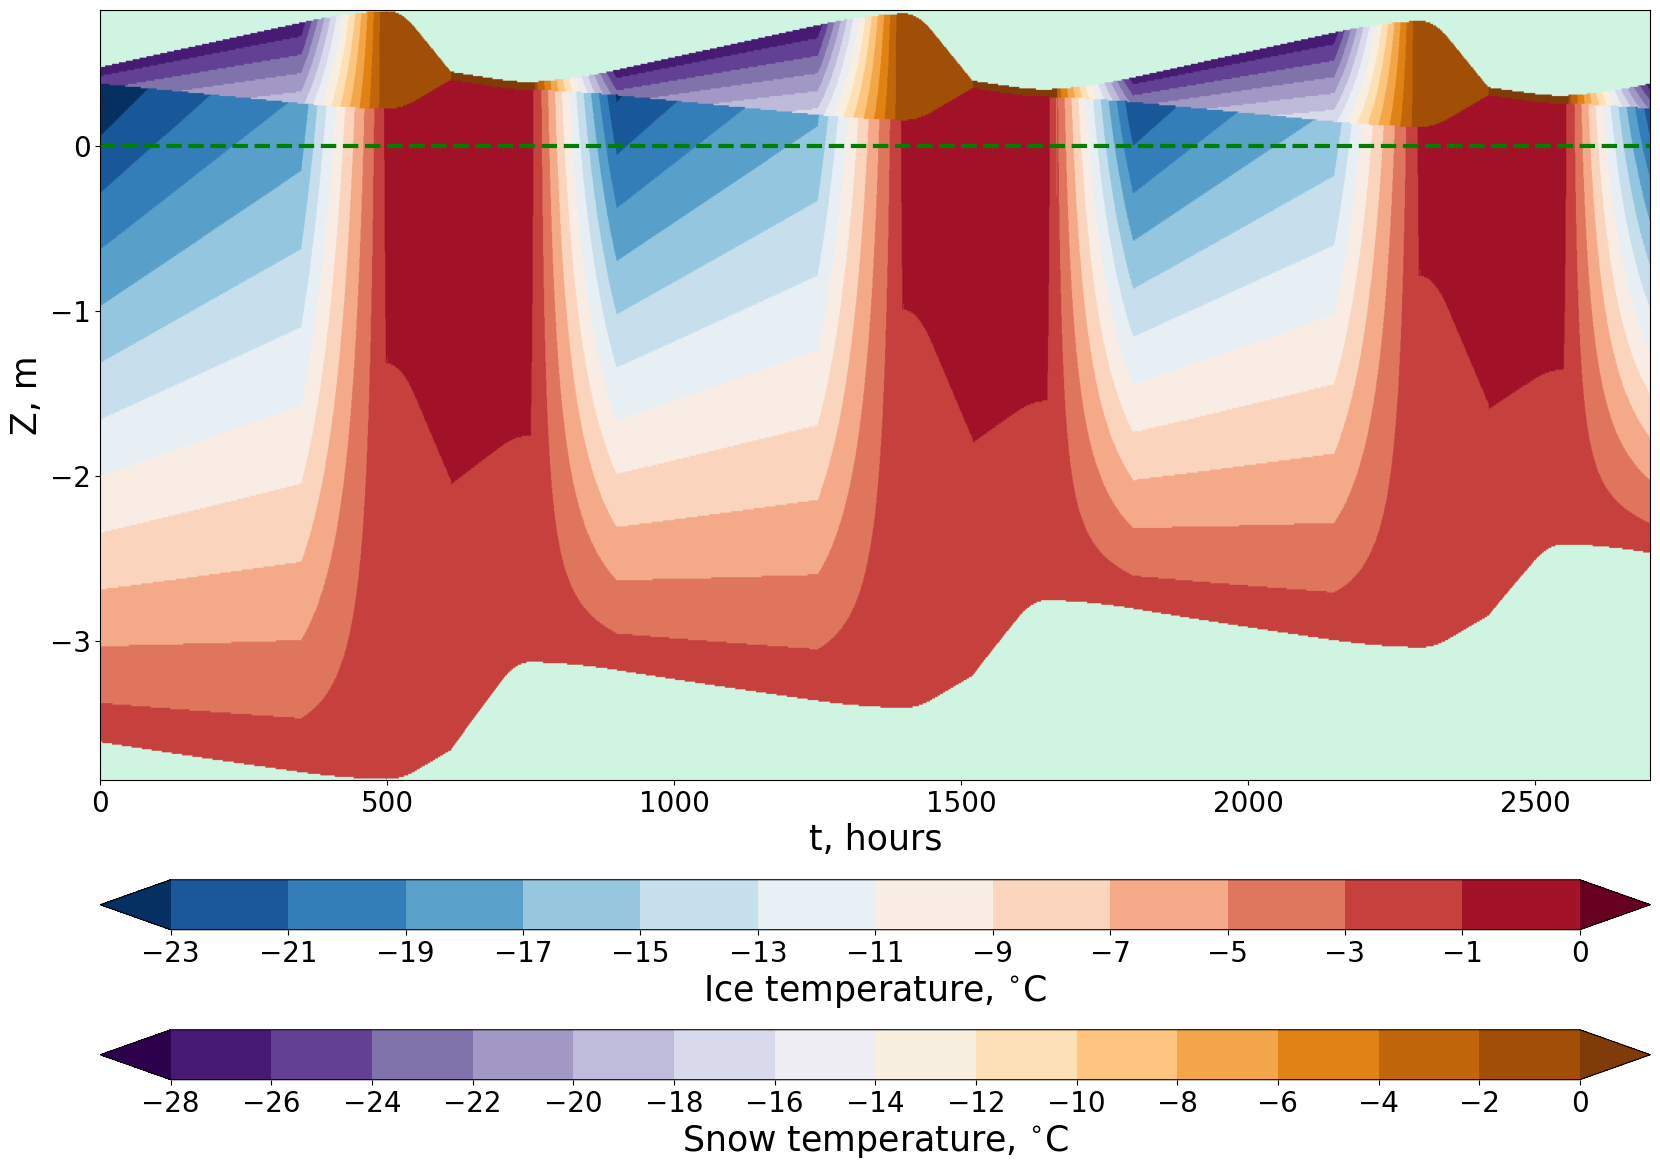

In [17]:
uv.timeseries_img(test_process_0d, y_points=500, figsize=(20, 10),
                  cmap_ice='RdBu_r', tmin_ice=-23, tmax_ice=0, step_ice=2.0,
                  cmap_snow='PuOr_r', tmin_snow=-28, tmax_snow=0, step_snow=2.0, 
                  color_waterline='green', savepath='media/model_0d.png')

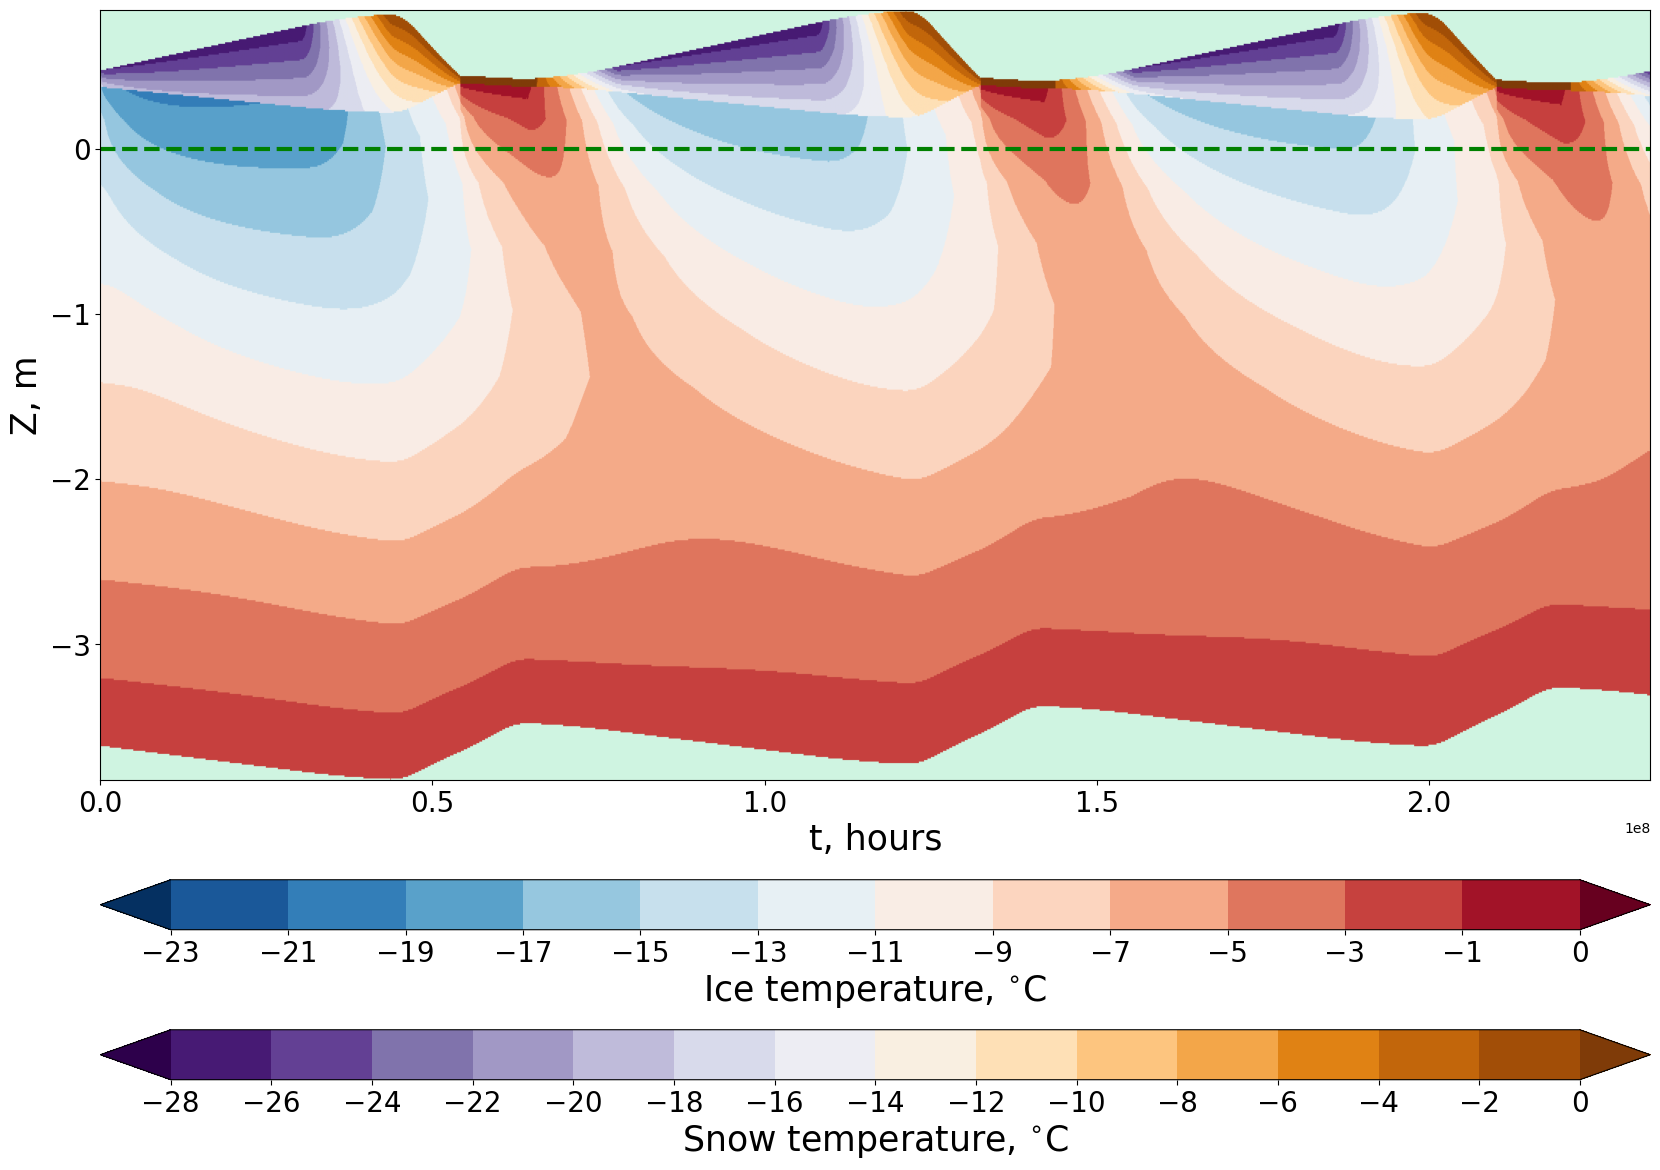

In [18]:
uv.timeseries_img(test_process_1d, y_points=500, figsize=(20, 10),
                  cmap_ice='RdBu_r', tmin_ice=-23, tmax_ice=0, step_ice=2.0,
                  cmap_snow='PuOr_r', tmin_snow=-28, tmax_snow=0, step_snow=2.0, 
                  color_waterline='green', savepath='media/model_1d.png')

In [ ]:
fig, ax_Tsu = plt.subplots(figsize=(20, 15))

for process, label, alpha in zip([test_process_0d, test_process_1d], ['0-D', '1-D'], [1.0, 0.7]):
    ax_Tsu.plot(process.timeline*24,
                np.where(process.snow_presence_history, process.sa_temp_history, process.is_temp_history),
                label=label, lw=4, alpha=alpha)
# ax_ice_th.set_title('Ice thickness', size=25)
ax_Tsu.set_ylabel(r'Surface temperature, $^o$C', size=25)
ax_Tsu.set_xlabel('Time, h.', size=25)
ax_Tsu.tick_params(labelsize=20)
ax_Tsu.legend(prop={'size': 20})
ax_Tsu.grid(ls='--')
fig.savefig('media/model_surf_temps.png', bbox_inches='tight' ,dpi=200)